In [23]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

#### Importing data 

In [24]:
Sales_features=pd.read_csv('data/Sales_features.csv')
Sales_stores=pd.read_csv('data/Sales_stores.csv')
Sales_test=pd.read_csv('data/Sales_test.csv')
Sales_train=pd.read_csv('data/Sales_train.csv')


In [25]:
# Merging Stores and Features into one 
dataset=Sales_features.merge(Sales_stores,how='inner',on='Store')

# Firstly we need to change the date format into year and week
dataset['year']=pd.DatetimeIndex(dataset['Date']).year ## Extracting 'year' data
dataset['week']=pd.DatetimeIndex(dataset['Date']).week ## Extracting 'week' data
dataset.head()


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,year,week
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2010,5
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315,2010,6
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315,2010,7
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315,2010,8
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315,2010,9


In [26]:
# Droping the MarkDown1 to 5 features from  dataset as they contain too many outliers

dataset.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'],axis=1,inplace=True)

In [33]:
df_train=Sales_train.merge(dataset,how='inner',on=['Store','IsHoliday','Date']) # merging Sales_train and dataset.
df_test=Sales_test.merge(dataset,how='inner',on=['Store','IsHoliday','Date']) # merging Sales_test and dataset.


In [34]:
df_test.drop(['Date'],axis=1,inplace=True)
df_train.drop(['Date'],axis=1,inplace=True)
df_test.shape,df_train.shape

((115064, 11), (421570, 12))

In [68]:
# dividing traning dataset into X, y sets
y=df_train['Weekly_Sales']
X=df_train.drop('Weekly_Sales',axis=1)

In [69]:
# Changing the 'IsHoliday' feature from bool type to int
X.IsHoliday = X.IsHoliday.replace({True: 1, False: 0})

In [70]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [71]:
# fit and transform the preprocessorr above defined
X = preprocessor.fit_transform(X)

In [72]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((337256, 13), (84314, 13))

#### Create an Evaluating Function to give all metrics after model Training

In [74]:
def evaluate_model(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    r2_square = r2_score(actual, predicted)
    return mae, rmse, r2_square

In [75]:
models = {
    "Linear Regression": LinearRegression(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False)
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 21621.6189
- Mean Absolute Error: 14546.2364
- R2 Score: 0.0893
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 21871.5095
- Mean Absolute Error: 14611.2531
- R2 Score: 0.0901


Lasso
Model performance for Training set
- Root Mean Squared Error: 21621.5996
- Mean Absolute Error: 14545.4644
- R2 Score: 0.0893
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 21871.3970
- Mean Absolute Error: 14610.3175
- R2 Score: 0.0901


Ridge
Model performance for Training set
- Root Mean Squared Error: 21621.5984
- Mean Absolute Error: 14545.7996
- R2 Score: 0.0893
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 21871.3828
- Mean Absolute Error: 14610.6687
- R2 Score: 0.0901


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 15462.0677
- Mean Absolute Erro

In [76]:
# Values of every model get the best 
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
5,Random Forest Regressor,0.976873
4,Decision Tree,0.963049
6,XGBRegressor,0.944442
7,CatBoosting Regressor,0.937938
3,K-Neighbors Regressor,0.303260
2,Ridge,0.090100
1,Lasso,0.090099
0,Linear Regression,0.090089
8,AdaBoost Regressor,-0.199850


### Random Forest Regressor

In [77]:
rf=RandomForestRegressor()
rf = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 97.68


Text(0, 0.5, 'Predicted')

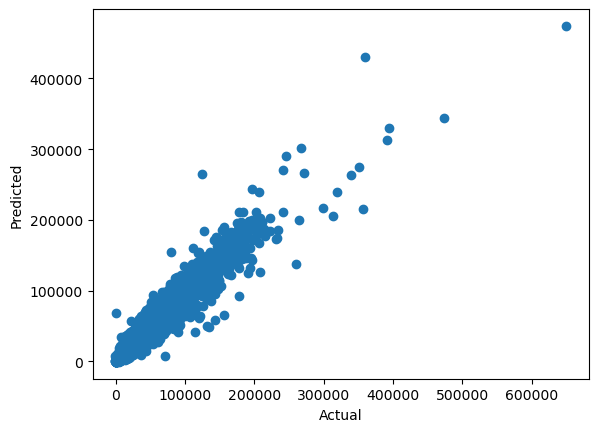

In [78]:
plt.scatter(y_test,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')